In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar100/meta
/kaggle/input/cifar100/file.txt
/kaggle/input/cifar100/test
/kaggle/input/cifar100/train


In [2]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate and print confusion matrix
from sklearn.metrics import confusion_matrix

# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform, he_normal
from tensorflow.keras.models import Model

# Image processing
from PIL import Image
from sklearn.model_selection import train_test_split

# Additional utilities
import os
import random
import tarfile
import pickle


import warnings 
warnings.filterwarnings('ignore')


In [3]:
# # Load the data
# train_path = '/kaggle/input/cifar100/train'
# test_path = '/kaggle/input/cifar100/test'   

In [4]:
# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [5]:
# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 100)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, 100)

In [6]:
# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [7]:
# Print data shapes for verification
print("Data successfully loaded!")
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data successfully loaded!
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


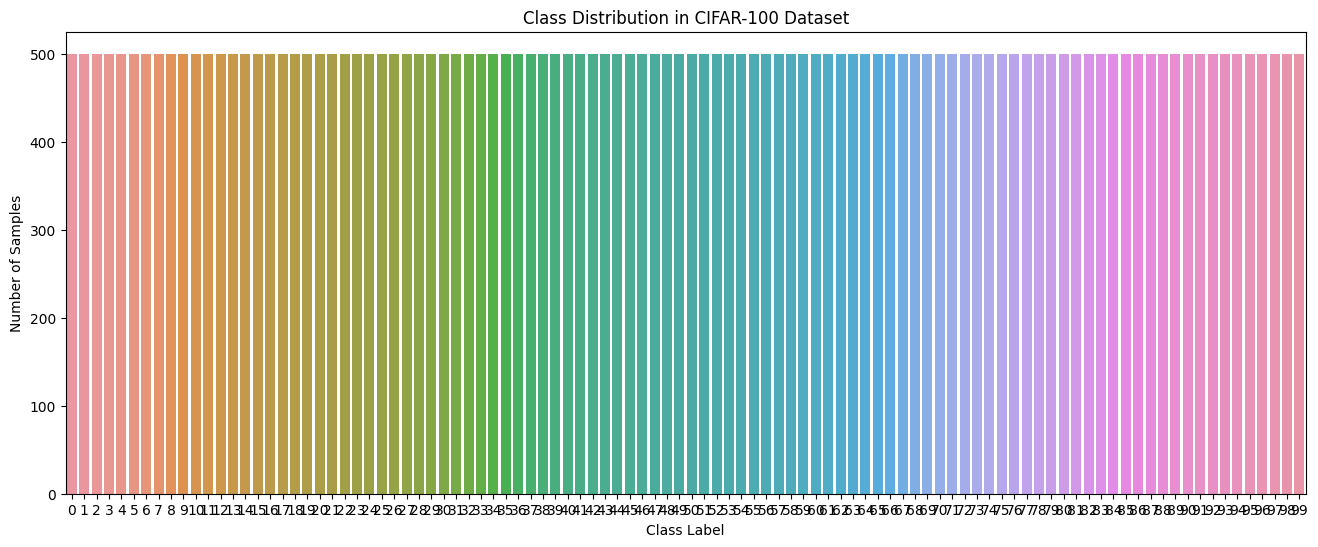

In [8]:
# Flatten the labels array for easier counting
y_train = y_train.flatten()

# Count occurrences of each class
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plot class distribution
plt.figure(figsize=(16, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in CIFAR-100 Dataset")
plt.show()

In [9]:
# Print data shapes for verification
print("Data successfully loaded!")
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Data successfully loaded!
Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000,)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [10]:
print(f"Normalized pixel range: {x_train.min()} to {x_train.max()}")

print(f"Shape of y_train_one_hot: {y_train_one_hot.shape}")

Normalized pixel range: 0.0 to 1.0
Shape of y_train_one_hot: (50000, 100)


In [11]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

In [12]:
datagen.fit(x_train)

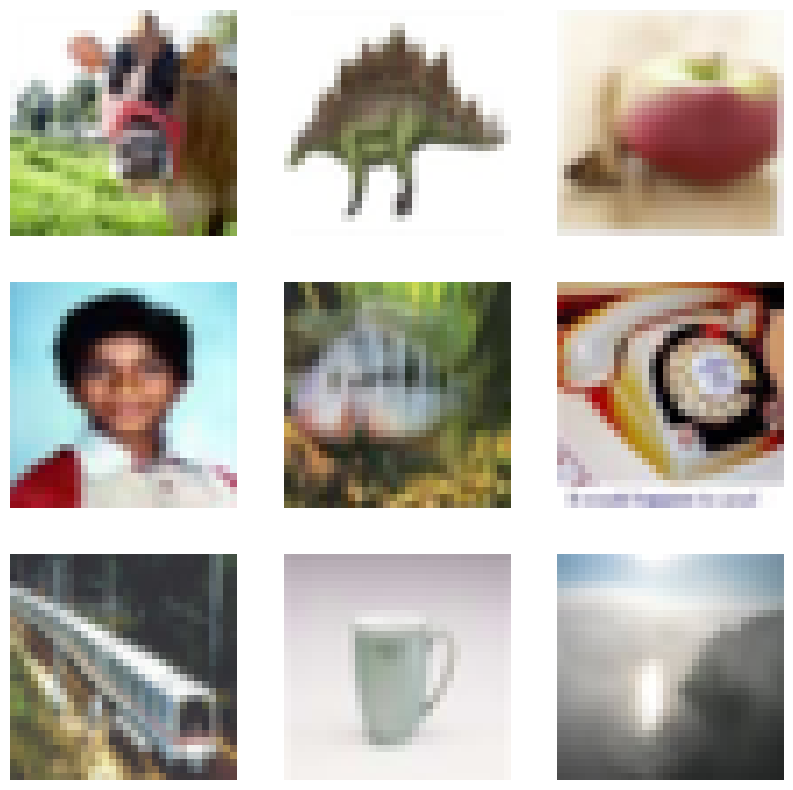

In [13]:
# Let's plot the first 9 images from the training set
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
plt.show()

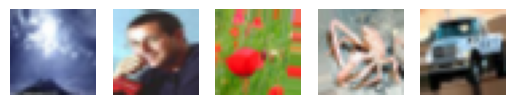

In [14]:
# Example of augmented images
augmented_images = next(datagen.flow(x_train, batch_size=5))
for i, img in enumerate(augmented_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [15]:
# Split training data into training and validation sets
x_train, x_val, y_train_one_hot, y_val_one_hot = train_test_split(
    x_train, y_train_one_hot, test_size=0.2, random_state=42
)
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val_one_hot: {y_val_one_hot.shape}")

Shape of x_val: (10000, 32, 32, 3)
Shape of y_val_one_hot: (10000, 100)


In [16]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    "best_baseline_model_a.keras",  # Change .h5 to .keras
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [17]:
# Create training and validation data generators outside the strategy scope
train_generator = datagen.flow(x_train, y_train_one_hot, batch_size=32)
validation_generator = datagen.flow(x_val, y_val_one_hot, batch_size=32)

### Model architecturing

In [18]:
# Identity Block
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    X_shortcut = X

    # First layer
    X = Conv2D(F1, (1, 1), padding='valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(F2, (f, f), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(F3, (1, 1), padding='valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)

    # Add shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# Convolutional Block
def convolutional_block(X, f, filters, s=2):
    F1, F2, F3 = filters
    X_shortcut = X

    # First layer
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Second layer
    X = Conv2D(F2, (f, f), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    # Third layer
    X = Conv2D(F3, (1, 1), padding='valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', kernel_initializer='he_normal')(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    # Add shortcut
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [19]:
# ResNet50 Model
def ResNet50(input_shape=(32, 32, 3), classes=10):
    X_input = Input(input_shape)

    # Zero padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, 3, [64, 64, 256], s=1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    # Stage 3
    X = convolutional_block(X, 3, [128, 128, 512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    X = convolutional_block(X, 3, [256, 256, 1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = convolutional_block(X, 3, [512, 512, 2048], s=2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # Average Pooling
    X = AveragePooling2D(pool_size=(2, 2))(X)

    # Output layer
    X = Flatten()(X)
    X = Dropout(0.5)(X)  # Regularization
    X = Dense(classes, activation='softmax', kernel_initializer='he_normal')(X)

    # Create model
    model = Model(inputs=X_input, outputs=X)
    return model

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

In [21]:
# Define the number of classes
num_classes = 100

# Create a strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    # Input shape
    input_shape = (32, 32, 3)

    # Create the base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    # Create the input layer
    inputs = Input(shape=input_shape)

    # Pass the input through the base model
    x = base_model(inputs)

    # Add custom top layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.0102 - loss: 4.7257 - val_accuracy: 0.0198 - val_loss: 4.5671 - learning_rate: 0.0010
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.0155 - loss: 4.5828 - val_accuracy: 0.0186 - val_loss: 4.5515 - learning_rate: 0.0010
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.0149 - loss: 4.5755 - val_accuracy: 0.0212 - val_loss: 4.5308 - learning_rate: 0.0010
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.0155 - loss: 4.5720 - val_accuracy: 0.0174 - val_loss: 4.5320 - learning_rate: 0.0010
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 36ms/step - accuracy: 0.0159 - loss: 4.5661 - val_accuracy: 0.0210 - val_loss: 4.5187 - learning_rate: 0.0010
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step - accuracy: 0.0149 - loss: 4.5638 - val_accuracy: 0.0232 - val_loss: 4.5095 - learning_rate: 0.0010
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 36ms/step -

In [23]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test_one_hot)
print(f"Test accuracy: {test_acc}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.0231 - loss: 4.4488
Test accuracy: 0.024800000712275505


### Trying a different arcitecture with varying augmentation

In [24]:
# Data Augmentation with MixUp
def mixup_generator(x, y, batch_size, alpha=0.2):
    while True:
        indices = np.random.permutation(len(x))
        shuffled_x = x[indices]
        shuffled_y = y[indices]
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            shuffled_x_batch = shuffled_x[i:i+batch_size]
            shuffled_y_batch = shuffled_y[i:i+batch_size]
            lam = np.random.beta(alpha, alpha, batch_size)
            x_mix = lam[:, None, None, None] * x_batch + (1 - lam[:, None, None, None]) * shuffled_x_batch
            y_mix = lam[:, None] * y_batch + (1 - lam[:, None]) * shuffled_y_batch
            yield x_mix, y_mix

In [25]:
train_gen = mixup_generator(x_train, y_train_one_hot, batch_size=64)

# Define learning rate scheduler
def lr_scheduler(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 30:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

# ResNet50-like model
def resnet50_custom(input_shape, classes):
    def conv_block(x, filters, kernel_size, strides, use_l2=False):
        reg = l2(1e-4) if use_l2 else None
        x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_regularizer=reg)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def residual_block(x, filters, use_l2=False):
        shortcut = x
        x = conv_block(x, filters, 3, strides=1, use_l2=use_l2)
        x = conv_block(x, filters, 3, strides=1, use_l2=use_l2)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 64, 3, strides=1)
    for _ in range(2):
        x = residual_block(x, 64, use_l2=True)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(classes, activation='softmax', kernel_regularizer=l2(1e-4))(x)
    return Model(inputs, outputs)

In [26]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [27]:
# Instantiate and compile model
model_1 = resnet50_custom((32, 32, 3), 100)
optimizer = Adam(learning_rate=0.001)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
lr_scheduler_cb = LearningRateScheduler(lr_scheduler)

In [28]:
# Train the model
history_1 = model_1.fit(
    train_gen,
    steps_per_epoch=len(x_train) // 64,
    epochs=50,
    validation_data=(x_test, y_test_one_hot),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler_cb]
)

Epoch 1/50


I0000 00:00:1733557038.980827      67 service.cc:145] XLA service 0x590195946340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733557038.980890      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733557038.980894      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  8/625 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.0026 - loss: 20.5142    

I0000 00:00:1733557043.958354      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - accuracy: 0.0891 - loss: 8.5716 - val_accuracy: 0.1570 - val_loss: 3.6781 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2844 - loss: 3.2604 - val_accuracy: 0.1646 - val_loss: 4.1517 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3815 - loss: 2.8640 - val_accuracy: 0.2128 - val_loss: 3.8169 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4590 - loss: 2.5932 - val_accuracy: 0.2262 - val_loss: 3.8005 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5046 - loss: 2.4381 - val_accuracy: 0.2592 - val_loss: 3.5771 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5588 - loss: 2.2946 - val_accuracy: 0.3044 - val_loss: 3.3125 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.5983 - loss: 2.1962

In [29]:
# Evaluate
test_loss, test_accuracy = model_1.evaluate(x_test, y_test_one_hot)
print(f"Test accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4349 - loss: 2.8066
Test accuracy: 0.43070000410079956


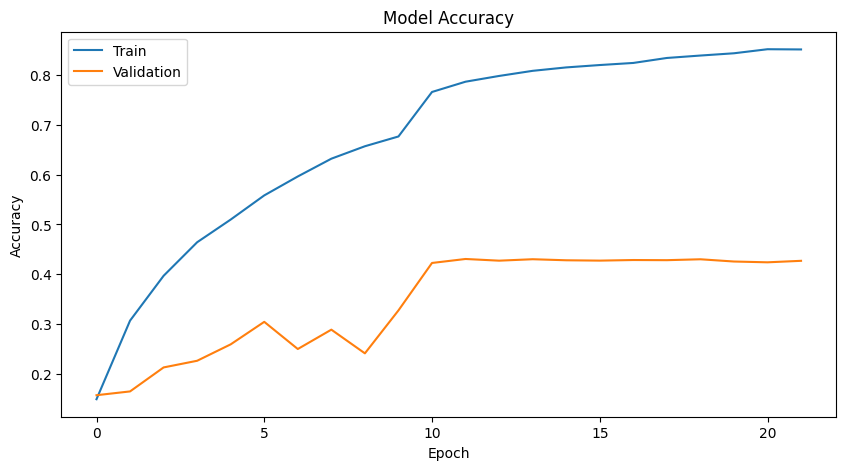

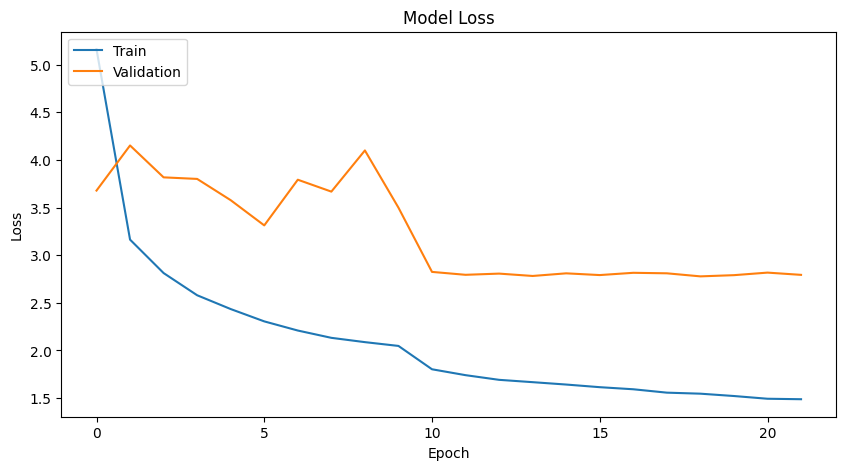

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Using same architecture with increased mixing intensity and reduced batchsize.

In [31]:
# Data Augmentation with MixUp
def mixup_generator_2(x, y, batch_size, alpha=0.5):
    while True:
        indices = np.random.permutation(len(x))
        shuffled_x = x[indices]
        shuffled_y = y[indices]
        for i in range(0, len(x), batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            shuffled_x_batch = shuffled_x[i:i+batch_size]
            shuffled_y_batch = shuffled_y[i:i+batch_size]
            lam = np.random.beta(alpha, alpha, batch_size)
            x_mix = lam[:, None, None, None] * x_batch + (1 - lam[:, None, None, None]) * shuffled_x_batch
            y_mix = lam[:, None] * y_batch + (1 - lam[:, None]) * shuffled_y_batch
            yield x_mix, y_mix

In [32]:
train_gen = mixup_generator_2(x_train, y_train_one_hot, batch_size=32)

# Define learning rate scheduler
def lr_scheduler(epoch):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    elif epoch < 30:
        return initial_lr * 0.1
    else:
        return initial_lr * 0.01

# ResNet50-like model
def resnet50_custom(input_shape, classes):
    def conv_block(x, filters, kernel_size, strides, use_l2=False):
        reg = l2(1e-4) if use_l2 else None
        x = Conv2D(filters, kernel_size, strides=strides, padding='same', kernel_regularizer=reg)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x

    def residual_block(x, filters, use_l2=False):
        shortcut = x
        x = conv_block(x, filters, 3, strides=1, use_l2=use_l2)
        x = conv_block(x, filters, 3, strides=1, use_l2=use_l2)
        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        return x

    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 64, 3, strides=1)
    for _ in range(2):
        x = residual_block(x, 64, use_l2=True)
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(classes, activation='softmax', kernel_regularizer=l2(1e-4))(x)
    return Model(inputs, outputs)

In [33]:
# Create a strategy for multi-GPU training
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
   
    # Instantiate and compile model
    model_2 = resnet50_custom((32, 32, 3), 100)
    optimizer = Adam(learning_rate=0.001)
    model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy')
    lr_scheduler_cb = LearningRateScheduler(lr_scheduler)

In [34]:
# Train the model
history_2 = model_2.fit(
    train_gen,
    steps_per_epoch=len(x_train) // 32,
    epochs=50,
    validation_data=(x_test, y_test_one_hot),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler_cb]
)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.0728 - loss: 7.6777 - val_accuracy: 0.0802 - val_loss: 5.4793 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.2335 - loss: 3.6683 - val_accuracy: 0.1556 - val_loss: 4.2986 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.3067 - loss: 3.4127 - val_accuracy: 0.1520 - val_loss: 5.0948 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.3565 - loss: 3.2717 - val_accuracy: 0.1906 - val_loss: 4.2690 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.4109 - loss: 3.2065 - val_accuracy: 0.2252 - val_loss: 3.8913 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.4458 - loss: 3.1800 - val_accuracy: 0.1682 - val_loss: 4.7939 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accura

In [35]:
# Evaluate
test_loss, test_accuracy = model_2.evaluate(x_test, y_test_one_hot)
print(f"Test accuracy: {test_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4185 - loss: 2.9987
Test accuracy: 0.4097999930381775


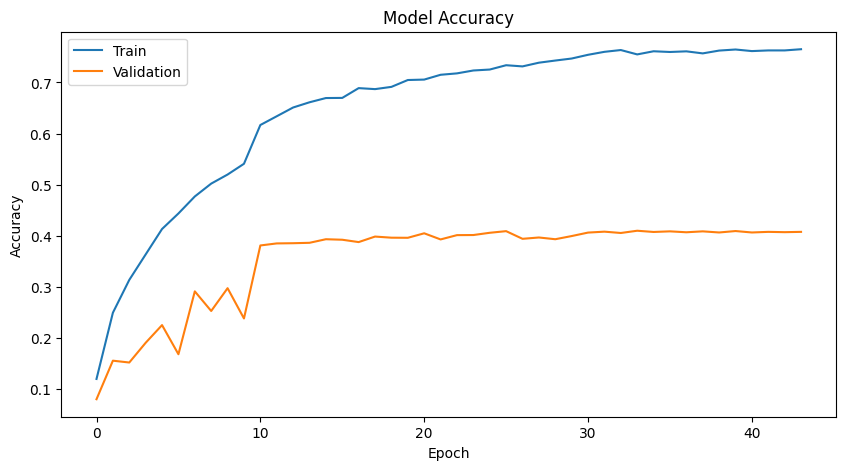

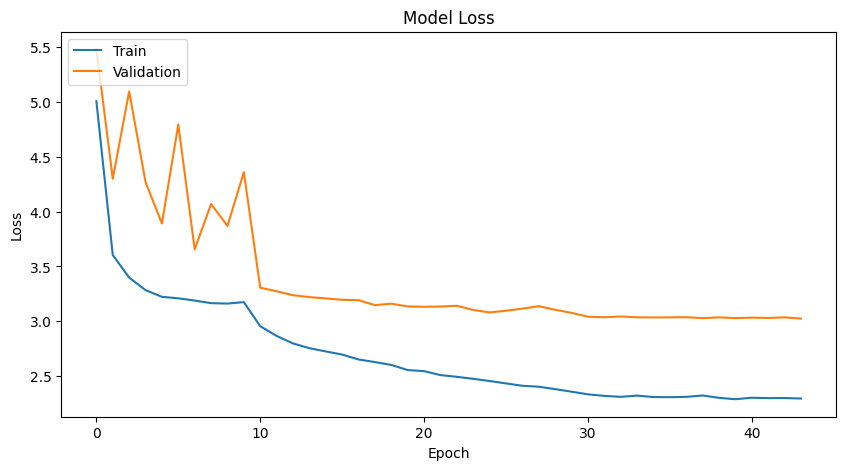

In [36]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Visualising prediction and misclassification

In [37]:
# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Find misclassified indices
misclassified_indices = np.where(y_pred_classes != y_true_classes)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step


In [38]:
# Get predictions
y_pred_1 = model_1.predict(x_test)
y_pred_classes_1 = np.argmax(y_pred_1, axis=1)
y_true_classes_1 = np.argmax(y_test_one_hot, axis=1)

# Find misclassified indices
misclassified_indices_1 = np.where(y_pred_classes_1 != y_true_classes_1)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [39]:
# Get predictions
y_pred_2 = model_2.predict(x_test)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)
y_true_classes_2 = np.argmax(y_test_one_hot, axis=1)

# Find misclassified indices
misclassified_indices_2 = np.where(y_pred_classes_2 != y_true_classes_2)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


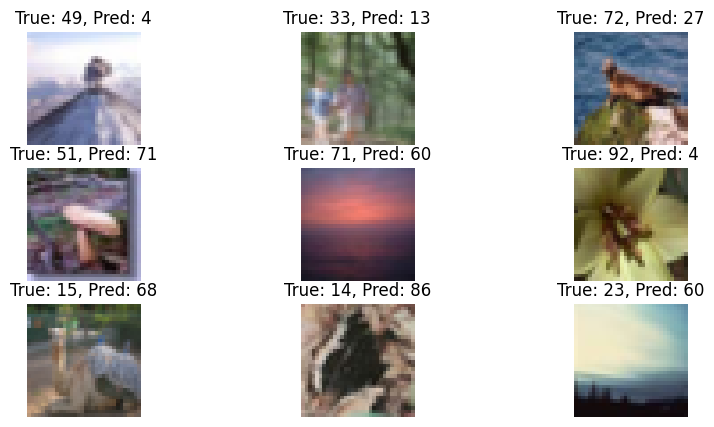

In [40]:
# Visualize misclassified images
plt.figure(figsize=(10, 5))
for i in range(min(len(misclassified_indices), 9)):  # Limit to 9 images for better visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[misclassified_indices[i]])
    plt.title(f"True: {y_true_classes[misclassified_indices[i]]}, Pred: {y_pred_classes[misclassified_indices[i]]}")
    plt.axis('off')
plt.show()

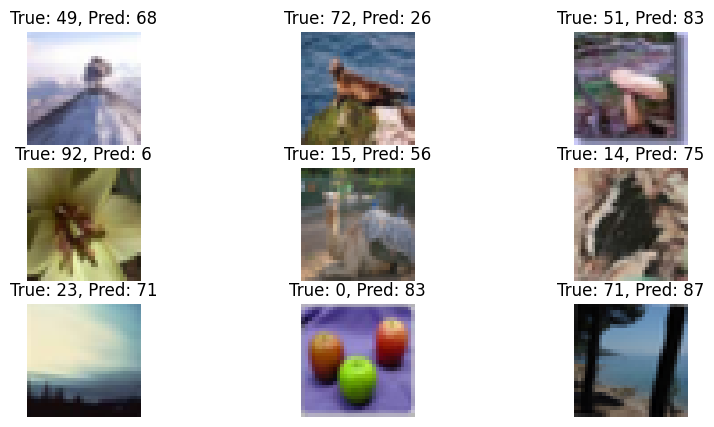

In [41]:
# Visualize misclassified images
plt.figure(figsize=(10, 5))
for i in range(min(len(misclassified_indices_1), 9)):  # Limit to 9 images for better visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[misclassified_indices_1[i]])
    plt.title(f"True: {y_true_classes_1[misclassified_indices_1[i]]}, Pred: {y_pred_classes_1[misclassified_indices_1[i]]}")
    plt.axis('off')
plt.show()

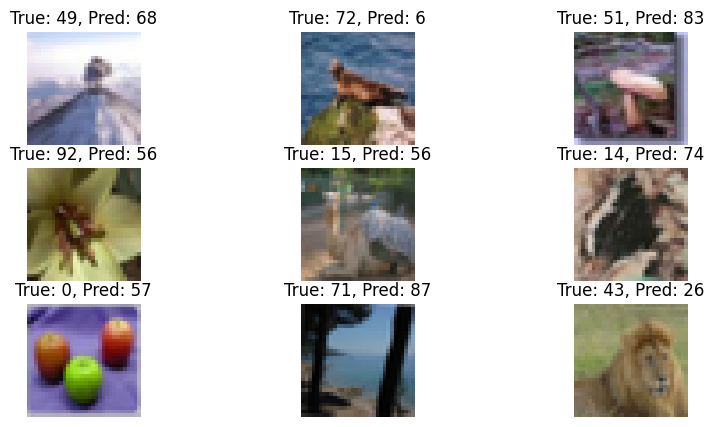

In [42]:
# Visualize misclassified images
plt.figure(figsize=(10, 5))
for i in range(min(len(misclassified_indices_2), 9)):  # Limit to 9 images for better visualization
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[misclassified_indices_2[i]])
    plt.title(f"True: {y_true_classes_2[misclassified_indices_2[i]]}, Pred: {y_pred_classes_2[misclassified_indices_2[i]]}")
    plt.axis('off')
plt.show()

In [43]:
from sklearn.metrics import classification_report

In [44]:
report_1 = classification_report(y_true_classes_1, y_pred_classes_1)

# Print the classification report
print(report_1)

              precision    recall  f1-score   support

           0       0.71      0.66      0.68       100
           1       0.54      0.60      0.57       100
           2       0.32      0.23      0.27       100
           3       0.23      0.24      0.24       100
           4       0.28      0.22      0.24       100
           5       0.44      0.29      0.35       100
           6       0.35      0.44      0.39       100
           7       0.38      0.41      0.39       100
           8       0.62      0.57      0.59       100
           9       0.57      0.66      0.61       100
          10       0.32      0.25      0.28       100
          11       0.35      0.22      0.27       100
          12       0.39      0.47      0.43       100
          13       0.36      0.35      0.35       100
          14       0.39      0.31      0.34       100
          15       0.35      0.25      0.29       100
          16       0.49      0.55      0.52       100
          17       0.48    

In [45]:
report_2 = classification_report(y_true_classes_2, y_pred_classes_2)

# Print the classification report
print(report_2)

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       100
           1       0.56      0.53      0.54       100
           2       0.27      0.26      0.26       100
           3       0.20      0.17      0.19       100
           4       0.20      0.15      0.17       100
           5       0.43      0.37      0.40       100
           6       0.40      0.44      0.42       100
           7       0.42      0.45      0.44       100
           8       0.61      0.48      0.54       100
           9       0.59      0.61      0.60       100
          10       0.34      0.33      0.33       100
          11       0.29      0.28      0.29       100
          12       0.44      0.44      0.44       100
          13       0.37      0.36      0.37       100
          14       0.26      0.39      0.31       100
          15       0.34      0.28      0.31       100
          16       0.51      0.43      0.47       100
          17       0.44    

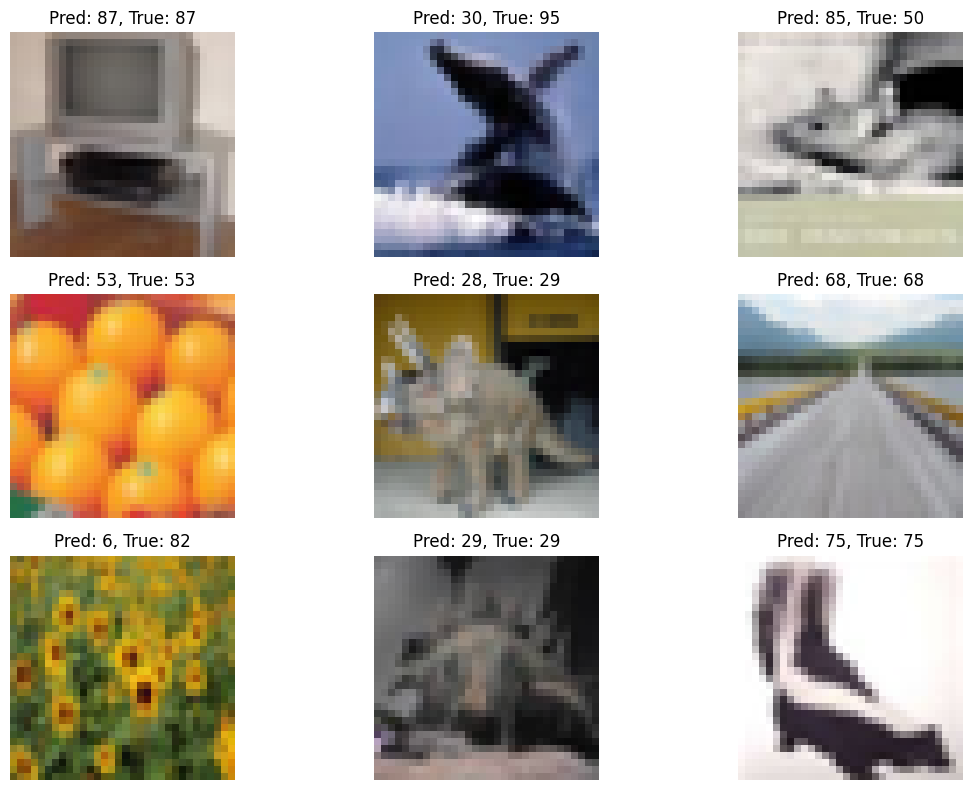

In [46]:
# Visualize predictions and actual labels with random selection
num_to_visualize = 9 

# Get random indices
random_indices = random.sample(range(len(x_test)), num_to_visualize)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Pred: {y_pred_classes_1[idx]}, True: {y_true_classes_1[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

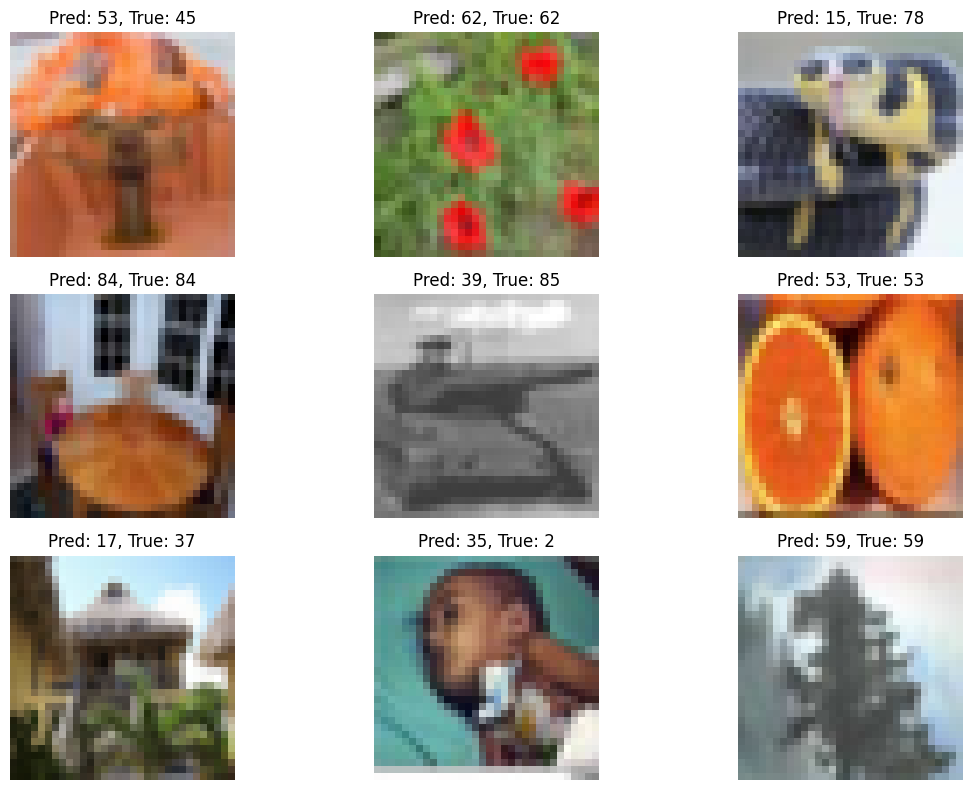

In [47]:
# Visualize predictions and actual labels with random selection
num_to_visualize = 9 

# Get random indices
random_indices = random.sample(range(len(x_test)), num_to_visualize)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx])
    plt.title(f"Pred: {y_pred_classes_2[idx]}, True: {y_true_classes_2[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

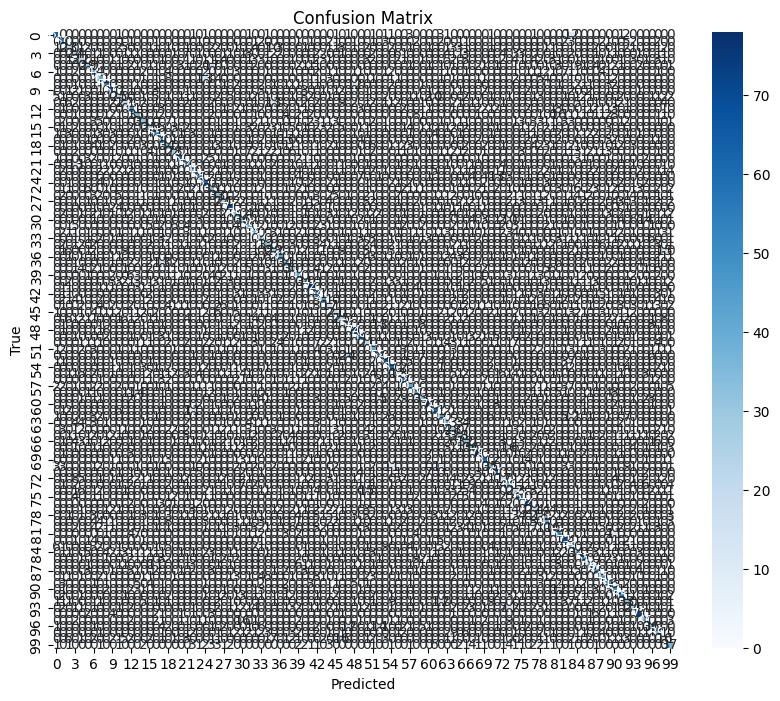

In [48]:
conf_matrix = confusion_matrix(y_true_classes_1, y_pred_classes_1)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [50]:
# Evaluate deep learning model
deep_learning_test_loss, deep_learning_test_acc = model_2.evaluate(x_test, y_test_one_hot)
print(f"Deep Learning Test Accuracy: {deep_learning_test_acc}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4185 - loss: 2.9987
Deep Learning Test Accuracy: 0.4097999930381775


In [51]:
# Train traditional machine learning models
# Flatten the image data for traditional ML models
x_train_flattened = x_train.reshape(x_train.shape[0], -1)
x_test_flattened = x_test.reshape(x_test.shape[0], -1)

In [52]:
# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(x_train_flattened, np.argmax(y_train_one_hot, axis=1))
logistic_accuracy = logistic_model.score(x_test_flattened, np.argmax(y_test_one_hot, axis=1))
print(f"Logistic Regression Test Accuracy: {logistic_accuracy}")

# Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(x_train_flattened, np.argmax(y_train_one_hot, axis=1))
random_forest_accuracy = random_forest_model.score(x_test_flattened, np.argmax(y_test_one_hot, axis=1))
print(f"Random Forest Test Accuracy: {random_forest_accuracy}")

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train_flattened, np.argmax(y_train_one_hot, axis=1))
knn_accuracy = knn_model.score(x_test_flattened, np.argmax(y_test_one_hot, axis=1))
print(f"K-Nearest Neighbors Test Accuracy: {knn_accuracy}")

Logistic Regression Test Accuracy: 0.1465
Random Forest Test Accuracy: 0.2138
K-Nearest Neighbors Test Accuracy: 0.1398


In [53]:
# Compare accuracies
print("\nModel Comparison:")
print(f"Deep Learning: {deep_learning_test_acc}")
print(f"Logistic Regression: {logistic_accuracy}")
print(f"Random Forest: {random_forest_accuracy}")
print(f"K-Nearest Neighbors: {knn_accuracy}")


Model Comparison:
Deep Learning: 0.4097999930381775
Logistic Regression: 0.1465
Random Forest: 0.2138
K-Nearest Neighbors: 0.1398
